In [1]:
import os
import cv2
import re
import pytesseract
import numpy as np

from os import listdir, mkdir
from os.path import isfile, isdir, exists, join
from copy import deepcopy
from pytesseract import Output
from collections import OrderedDict, Counter
from pprint import pprint


TABLE_THRESHOLD = 200

def load_page(image_dir, image_name, page, image_extension='.jpg'):
    """
    parameters :
        image_dir (str): directory path of images to load
        image_name (str): name of image to load
        page (int or str): page of image to load
        image_extension (str): file extension of image file (.jpg, .jpeg, .png, ... )
    return :
        loaded_image (np.ndarray): loaded single image of numpy.ndarray type
    """
    image_path = join(image_dir, image_name)
    file = join(image_dir, image_name, str(page)+image_extension)
    if isfile(file):
        return cv2.imread(file, cv2.IMREAD_COLOR)
    

def show(image, temp_dir=None):
    """
    parameters :
        image (numpy.ndarray) : input image to show
        temp_dir (str) : path of temporary directory to write temporary image file 
    return :
        object (PIL.JpegImagePlugin.JpegImageFile) : image file of PIL.JpegImagePlugin.JpegImageFile type
        (Use show() method of PIL.JpegImagePlugin.JpegImageFile object to open image as a file; example - show(image).show())
    """
    from PIL import Image
    temp_dir = temp_dir or os.path.abspath("./")
    temp_image_name = 'temp_show.jpg'
    cv2.imwrite('temp_show.jpg', image)
    _image = Image.open('temp_show.jpg')
    if exists(join(temp_dir, temp_image_name)):
        os.remove(join(temp_dir, temp_image_name))
    return _image
    
    
def generate_blank_img(width, height, color=255):
    blank_image = np.zeros((height, width, 3), np.uint8)
    blank_image[:, :] = (color, color, color)  # white
    return blank_image


def crop_target(image, coordinate, black_space=20, color=255):
    half = black_space//2
    x, y, w, h = coordinate
    temp_img = generate_blank_img(width=w+black_space, height=h+black_space, color=color)
    if len(image.shape) == 3:
        temp_img[half:half+h, half:half+w, :] = image[y:y+h, x:x+w, :]
    elif len(image.shape) == 2:
        temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2GRAY)
        temp_img[half:half+h, half:half+w] = image[y:y+h, x:x+w]
    return temp_img


def rotate_threshold(tilted_image, angle=None):
    raw_image = deepcopy(tilted_image)
    (h, w) = raw_image.shape[:2]
    center = (w // 2, h // 2)  # 회전 중심
    
    # Find the tilted angle by using threshold image in case that there is no 'angle' input
    if angle is None:
        image = 255 - tilted_image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        find_horizontal = find_horizontal_lines_2(image)
        contours, _ = cv2.findContours(find_horizontal, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        angle_list = []
        for cnt in contours:
            angle_list.append(cv2.minAreaRect(cnt)[-1])
        angle_set = set(angle_list)
        if -90.0 in angle_set: angle_set.remove(-90.0)
        if 0.0 in angle_set: angle_set.remove(0.0)
        if len(angle_set) > 0: 
            angle = max(angle_set)
        else:
            angle = 0
        if angle < -45:
            angle = (90 + angle)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)  # 회전
        rotated_image = cv2.warpAffine(raw_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        rotated_image = cv2.threshold(rotated_image, 30, 255, 0)[1]
    else:
        M = cv2.getRotationMatrix2D(center, angle, 1.0)  # 회전
        rotated_image = cv2.warpAffine(raw_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated_image, angle


def cvtColor(image):
    if len(image.shape) == 3:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # gray scale로 변환
    else:
        return image


def upper_threshold(image, _threshold=215):
    gray = cvtColor(image)
    _temp_gray = deepcopy(gray)
    _temp_gray[_temp_gray > _threshold] = 255
    return _temp_gray


def find_vertical_lines(image, line_threshold=30):
    gray_image = cvtColor(image)
    reversed_image = 255 - gray_image
    dilated_reversed_image = cv2.dilate(reversed_image, None, iterations=1)
    
    # Defining a kernel length
    ### todo 
    ### 최적의 값 찾기
#     kernel_vlength = np.array(reversed_image).shape[1]//10
#     kernel_vlength = 145 # 20200115 변경 / sample 20150102181918000001 - 9.jpg
    kernel_vlength = 50 # 20200120 변경 / sample 0013150017 - 7.jpg
    
    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_vlength))
    
    vertical_eroded_image = cv2.erode(dilated_reversed_image, vertical_kernel, iterations=1)
    dilated_vertical_eroded_image = cv2.dilate(vertical_eroded_image, None, 3)
    dilated_dilated_vertical_eroded_image = cv2.dilate(dilated_vertical_eroded_image, vertical_kernel, 3)
        
    ### threshold 변경 (10 -> 30)
    _, threshold_dilated_dilated_vertical_eroded_image = \
    cv2.threshold(dilated_dilated_vertical_eroded_image, line_threshold, 255, 0)
        
    return threshold_dilated_dilated_vertical_eroded_image


def find_horizontal_lines(image, line_threshold=30):
    gray_image = cvtColor(image)
    reversed_image = 255 - gray_image
    dilated_reversed_image = cv2.dilate(reversed_image, None, iterations=1)
    
    # Defining a kernel length
    kernel_hlength = np.array(reversed_image).shape[1]//12
    
    ### todo 
    ### 최적의 값 찾기
    kernel_hlength = 85
    
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_hlength, 1))
    
    horizontal_eroded_image = cv2.erode(dilated_reversed_image, horizontal_kernel, iterations=1)
    dilated_horizontal_eroded_image = cv2.dilate(horizontal_eroded_image, None, 3)
    dilated_dilated_horizontal_eroded_image = cv2.dilate(dilated_horizontal_eroded_image, horizontal_kernel, 3)
    
#     show(dilated_dilated_horizontal_eroded_image).show()
    
    ### threshold 변경 (10 -> 50)
    _, threshold_dilated_dilated_horizontal_eroded_image = \
    cv2.threshold(dilated_dilated_horizontal_eroded_image, line_threshold, 255, cv2.THRESH_BINARY)
#     cv2.threshold(dilated_dilated_horizontal_eroded_image, 10, 255, cv2.THRESH_BINARY)
    
    return threshold_dilated_dilated_horizontal_eroded_image
    

def find_table(image, table_threshold=TABLE_THRESHOLD, line_threshold=30):
    threshold_image = upper_threshold(image, table_threshold)
    vertical_lines_image = find_vertical_lines(threshold_image, line_threshold)
    horizontal_lines_image = find_horizontal_lines(threshold_image, line_threshold)
    
    alpha = 1
    beta = 1
    merged_image = cv2.addWeighted(vertical_lines_image, alpha, horizontal_lines_image, beta, 0.0)
    dilated_merged_image = cv2.dilate(merged_image, None, 1)
    
    return dilated_merged_image


### 감정평가표 추가
def find_horizontal_lines_2(image):
    gray_image = cvtColor(image)
    reversed_image = 255 - gray_image
    dilated_reversed_image = cv2.dilate(reversed_image, None, iterations=1)
    
    # Defining a kernel length
    kernel_hlength = np.array(reversed_image).shape[1]//5
    
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_hlength, 1))
    
    horizontal_eroded_image = cv2.erode(dilated_reversed_image, horizontal_kernel, iterations=1)
    dilated_horizontal_eroded_image = cv2.dilate(horizontal_eroded_image, None, 3)
    dilated_dilated_horizontal_eroded_image = cv2.dilate(dilated_horizontal_eroded_image, horizontal_kernel, 3)

    _, threshold_dilated_dilated_horizontal_eroded_image = \
    cv2.threshold(dilated_dilated_horizontal_eroded_image, 10, 255, cv2.THRESH_BINARY)
    
    return threshold_dilated_dilated_horizontal_eroded_image


def _sort_including_table(tables):
    """
    표 인식 및 추출 시 검출한 table coordinate에서 
    table 내부에 셀 또는 sub-table을 같이 인식하는 경우 제외시켜주는 함수
    """
    removed_tables = []
    for table in tables:
        temp_tables = [_ for _ in tables if _ != table and _ not in removed_tables]
        for _table in temp_tables:
            if table[0] <= _table[0]+5 and table[0]+table[2] >= (_table[0]+_table[2]-20) \
            and table[1] <= _table[1]+5 and table[1]+table[3] >= (_table[1]+_table[3]-30) \
            and table[2] >= _table[2]-5 \
            and table[3] >= _table[3]-5:
                removed_tables.append(_table)
    for pop_table in removed_tables:
        tables.pop(tables.index(pop_table))
    tables = sorted(tables, key=lambda crd: crd[1])
    

def _table_detector(table_image, raw_image_area=None):
    H, W = table_image.shape[:2]
    raw_image_area = raw_image_area or H*W
    contours, _ = cv2.findContours(table_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    tables = []
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.01 * peri, True)

        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            rect_area = w * h

            if 70000 <= rect_area <= 2500000 \
            and rect_area / raw_image_area < 0.6 \
            and w / h > 0.2 \
            and w >= 900 \
            and x >= 50:
                tables.append([x, y, w, h])
    
    _sort_including_table(tables)
    tables = sorted(tables, key=lambda coordinate: coordinate[1])
    return tables


def _find_style_lines(table_image):
    H, W = table_image.shape[:2]
    contours, _ = cv2.findContours(table_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    tables = []
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.01 * peri, True)

        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            rect_area = w * h

            if 2250000 <= rect_area <= 3500000:
                if h >= int(H*0.75) and x != 0 and y != 0 \
                or w >= int(W*0.85) and x != 0 and y != 0:
                    tables.append([x, y, w, h])
    
    _sort_including_table(tables)
    tables = sorted(tables, key=lambda coordinate: coordinate[1])
    
    # 특수 양식선 검출을 위한 세로선 검출 추가
    if len(tables) == 0:
        vertical_lines = _find_vertical_lines_in_a_cell(table_image)
        if len(vertical_lines) == 0:
            return tables
        
        max_height = max([_[3] for _ in vertical_lines])
        if max_height < int(H*0.75):
            return tables
        
        left_line = None
        right_line = None
        for vertical_line in vertical_lines:
            if vertical_line[3] >= int(H*0.75) \
            and vertical_line[0] < 300:
                left_line = [_ for _ in vertical_line]
                break
                
        for vertical_line in reversed(vertical_lines):
            if vertical_line[3] >= int(H*0.75) \
            and vertical_line[0] > W - 300:
                right_line = [_ for _ in vertical_line]
                break
        
        if left_line and right_line:
            tables.append([
                left_line[0], 
                min(left_line[1], right_line[1]), 
                right_line[0] + right_line[2] - left_line[0] + 1,
                max(left_line[3], right_line[3])
            ])
        
    return tables


def _find_horizontal_lines_coordinate(table_image, x_start, x_end, y_start, y_end):
    # line의 후보가 되는 선들 뽑아내기
    y_indices = np.zeros(shape=[table_image.shape[0]], dtype=np.int32)
    x_start_info = []
    for y_index, y in enumerate(range(y_start, y_end)):
        _array = np.where(table_image[y, x_start:x_end] == 255)[0]
        if len(_array) > (x_end-x_start+1)//2 \
        and _array[0] > 0 \
        and (_array[-1] - _array[0] + 1) == len(_array):
            y_indices[y] = y
            x_start_info.append([x_start+_array[0], x_start+_array[-1]])
    
    if len(np.where(y_indices > 0)[0]) == 0:
        return []
    
    candidate_list = []
    for _index, y_index in enumerate(np.where(y_indices > 0)[0]):
        _x_start, _x_end = x_start_info[_index]
        candidate_list.append([_x_start, y_index, _x_end-_x_start+1, 1])
    
    # 연속된 candidate 중에서 line 뽑아내기
    coordinate_list = []
    base = None
    h_count = 0
    for index, candidate in enumerate(candidate_list):
        if not base:
            base = [_ for _ in candidate]
            h_count += 1
        else:
            if base[0] - 5 <= candidate[0] <= base[0] + 5 \
            and base[1] + h_count + 1 >= candidate[1]:
                base[2] = max([base[2], candidate[2]])
                h_count += 1
        
            elif h_count >= 2:
                coordinate_list.append([base[0], base[1], base[2], h_count])
                base = [_ for _ in candidate]
                h_count = 1
            else:
                base = [_ for _ in candidate]
                h_count = 1
        if index == len(candidate_list)-1 and h_count >= 2:
            coordinate_list.append([base[0], base[1], base[2], h_count])

    base = None
    pop_list = []
    for index, crd in enumerate(coordinate_list):
        if crd[3] > 30:
            continue
        
        if sum(table_image[crd[1]-50:crd[1]+50, (crd[0]+3)] == 255) >= 40:
            if sum(table_image[crd[1]-50:crd[1]+50, (crd[0]+13)] == 255) <= 20:
                pop_list.append(crd)
        elif crd[0] == x_start:
            pop_list.append(crd)
        
        if index == 0 and len(coordinate_list) > 1:
            if crd[0] - coordinate_list[1][0] > 30:
                pop_list.append(crd)
        
        # 내부 표선 및 분수식의 선과 같은 비정상적인 선 제거
        elif 0 < index < len(coordinate_list) - 1:
            # 비정상인지 판단이기 위한 base 설정 (init base 설정)
            if base is None:
                base = [_ for _ in coordinate_list[index-1]]
            
            # 비정상인지 체크
            if abs(crd[0] - base[0]) > 30 \
            and abs(crd[0] - coordinate_list[index+1][0]) > 30:
                pop_list.append(crd)
            # 비정상이 아니라고 판단될 시 base 업데이트 (현재의 coordinate)
            else:
                base = [_ for _ in coordinate_list[index-1]]                
        
    for _pop in pop_list:
        if _pop in coordinate_list:
            coordinate_list.pop(coordinate_list.index(_pop))
    
    return coordinate_list


def _find_vertical_lines_in_a_cell(cell_image):
    h, w = cell_image.shape[:2]
    # line의 후보가 되는 선들 뽑아내기
    candidate_list = []
    for x in range(1, w):
        y_count = 0
        start = 0
        for index, point in enumerate(cell_image[:, x]):
            if point == 255 and not start:
                start_index = index + 1
                y_count += 1
                start = 1
                
            if start:
                for height, _point in enumerate(cell_image[start_index:, x]):
                    if start_index+height+1 >= h:
                        break
                    if _point == 255:
                        y_count += 1
                    elif _point != 255 \
                    and cell_image[start_index+height+1, x] != 255 \
                    and height > 30:
                        _coordinate = (x, start_index, 1, height)
                        candidate_list.append(_coordinate)
                        break
                    elif _point != 255 and cell_image[start_index+height+1, x] != 255:
                        break
                break
#             elif index >= cell_image.shape[0]//2 and y_count == 0:
#                 break
        if y_count >= len(cell_image[:, x])//2:
            _coordinate = (x, start_index, 1, height)
            if _coordinate not in candidate_list:
                candidate_list.append(_coordinate)
        
    # 연속된 candidate 중에서 line 뽑아내기
    coordinate_list = []
    base = None
    w_count = 0
    for index, candidate in enumerate(candidate_list):
        if not base:
            base = [_ for _ in candidate]
            w_count += 1
        else:
            if base[1] - 2 <= candidate[1] <= base[1] + 2 \
            and base[3] - 2 <= candidate[3] <= base[3] + 2 \
            and base[0] + w_count + 1 >= candidate[0]:
                w_count += 1

            elif w_count >= 2:
                coordinate_list.append([base[0], base[1], w_count, base[3]])
                base = [_ for _ in candidate]
                w_count = 1
            else:
                base = [_ for _ in candidate]
                w_count = 1
        if index == len(candidate_list)-1 and w_count >= 2:
            coordinate_list.append([base[0], base[1], w_count, base[3]])
    
    return coordinate_list
    

def table_detector(image, raw_image_area=None, table_threshold=200, line_threshold=30):
    # rotate 수행
    table_image = find_table(image, table_threshold, line_threshold)
    table_image, angle = rotate_threshold(table_image)
    image = rotate_threshold(image, angle)[0]
    raw_image_area = raw_image_area or image.shape[0]*image.shape[1]
    
    style_lines = _find_style_lines(table_image)
    _tables_1 = _table_detector(table_image, raw_image_area)
    
    if len(_tables_1) > 0:
        _table_images_1 = [crop_target(image, _table) for _table in _tables_1]
        
    if len(style_lines) == 1:
        x_start = style_lines[0][0] + 30
        x_end = style_lines[0][0] + style_lines[0][2] - 30
        y_start = style_lines[0][1] + 30
        y_end = style_lines[0][1] + style_lines[0][3] - 30
    else:
        x_start = 100
        x_end = table_image.shape[1] - 100
        y_start = 350
        y_end = table_image.shape[0] - 100
        
    line_list = _find_horizontal_lines_coordinate(table_image, x_start, x_end, y_start, y_end)
    if len(line_list) > 0:
        _tables_2, _table_images_2 = _distinguish_contents(image, table_image, line_list, x_start)
    elif len(_tables_1) > 0:
        return _tables_1, _table_images_1
    else:
        return [], []
    
    tables = []
    table_images = []
    for _index in range(len(_tables_1)):
        tables.append(_tables_1[_index])
    
    for _index in range(len(_tables_2)):
        tables.append(_tables_2[_index])
        
    _sort_including_table(tables)    
    for table in tables:
        if table in _tables_1:
            table_images.append(_table_images_1[_tables_1.index(table)])
        if table in _tables_2:
            table_images.append(_table_images_2[_tables_2.index(table)])
            
    return tables, table_images


def delete_inner_box(contour_box):
    try:
        index_list = []
        remove_list = []
        for alpha in range(len(contour_box)):
            for beta in range(len(contour_box)):
                if alpha != beta:
                    x1, y1, w1, h1 = contour_box[alpha]
                    x2, y2, w2, h2 = contour_box[beta]
                    if 5 < abs(x1 - x2) < max([w1, w2]) and 5 < abs(y1 - y2) < max([h1, h2]) and w2 < w1:
                        index_list.append(beta)

        for index in sorted(set(index_list)):
            component = contour_box[index]
            remove_list.append(component)

        for remove_needed in remove_list:
            contour_box.remove(remove_needed)

        return contour_box

    except:

        return contour_box


def union_box(text_box):
    _continue = True

    while True:
        if _continue:

            index_list = []
            remove_list = []
            union_list = []

            temp_consistant = sum([h[3] for h in text_box]) / len(text_box)
            r = temp_consistant * 0.2

            for alpha in range(len(text_box)):
                for beta in range(len(text_box)):
                    if alpha != beta:
                        x1, y1, w1, h1 = text_box[alpha]
                        x2, y2, w2, h2 = text_box[beta]
                        if abs(y1 - y2) < r or abs((y1 + h1) - (y2 + h2)) < r:
                            union_x = min([x1, x2])
                            union_y = min([y1, y2])
                            union_w = max([x1 + w1, x2 + w2]) - union_x
                            union_h = max([y1 + h1, y2 + h2]) - union_y

                            new = [union_x, union_y, union_w, union_h]
                            if new not in union_list:
                                union_list.append(new)
                            index_list.append(alpha)
                            index_list.append(beta)

            for index in sorted(set(index_list)):
                component = text_box[index]
                remove_list.append(component)

            if remove_list != []:
                for remove_needed in remove_list:
                    text_box.remove(remove_needed)

                for new_box in union_list:
                    text_box.append(new_box)
            else:
                _continue = False
                break

    return sorted(text_box, key=lambda c: (c[1] + c[3], c[0] + c[2]))


def row_box_detector(image):
    try:
        preprocessed_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        preprocessed_img = image

    # erode 적용
    preprocessed_img = cv2.erode(preprocessed_img, None, 1)

    # 전처리
    temp = cv2.threshold(preprocessed_img, 170, 255, cv2.THRESH_BINARY)[1]
    temp = cv2.bitwise_not(temp)
    temp = cv2.morphologyEx(temp, cv2.MORPH_CLOSE, (5, 5), iterations=10)
    temp = cv2.bitwise_not(temp)

    contours, _ = cv2.findContours(temp, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    unit_rect = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        y = y - 10  #####

        rect_area = w * h  # area size
        aspect_ratio = float(w) / h  # ratio = width/height

        if h and (200 < rect_area < 5000 or 65 <= h <= 75):
            unit_rect.append([x, y, w, h])

    if len(unit_rect) == 0:
        return []

    unit_rect = sorted(unit_rect, key=lambda c: (c[1] + c[3], c[0] + c[2]))

    # 내부포함 박스 제거
    unit_rect = delete_inner_box(contour_box=unit_rect)

    # 텍스트 유닛 높이의 평균 계산
    r = int(sum([h[3] for h in unit_rect]) / len(unit_rect))

    # 텍스트 라인 갯수 계산
    temp = sorted(set([y[1] // r for y in unit_rect]))
    row_list = [0] * len(temp)

    # 같은 줄에 있는 텍스트 유닛 수집 및 하나의 row_box로 재결합
    for i in range(len(temp)):
        same_row_text = []

        for text_unit in unit_rect:
            if text_unit[1] // r == temp[i]:
                same_row_text.append(text_unit)

        same_row_text = sorted(same_row_text, key=lambda x: x[0])

        start_x = same_row_text[0][0]
        start_y = min([y[1] for y in same_row_text])

        length = same_row_text[-1][0] + same_row_text[-1][2] - start_x
        height = max([h[3] for h in same_row_text])

        row_list[i] = [start_x, start_y, length, height]

    row_list = union_box(text_box=row_list)
    return row_list
        

def remove_table(image, table_threshold=TABLE_THRESHOLD):
    def _remove_table(image_to_remove, table_image):
        temp_image = deepcopy(image_to_remove)
        vlength = table_image.shape[0]
        for v in range(vlength):
            _remove_indices = np.where(table_image[v,:] == 255)[0]
            temp_image[v, _remove_indices] = 255
        return temp_image
    
    gray_image = cvtColor(image)
    
    # Processing to remove color in cells
    _, threshold_image = cv2.threshold(gray_image, table_threshold, 255, cv2.THRESH_BINARY)
    reversed_image = 255 - threshold_image
    
    dilated_reversed_image = cv2.dilate(reversed_image, None, iterations=1)

    # Defining a kernel length
    kernel_vlength = np.array(reversed_image).shape[1]//22
    kernel_hlength = np.array(reversed_image).shape[1]//9

    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_vlength))

    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_hlength, 1))

    vertical_eroded_image = cv2.erode(dilated_reversed_image, vertical_kernel, iterations=1)
    dilated_vertical_eroded_image = cv2.dilate(vertical_eroded_image, None, 3)
    dilated_dilated_vertical_eroded_image = cv2.dilate(dilated_vertical_eroded_image, vertical_kernel, 3)

    _, threshold_dilated_dilated_vertical_eroded_image = \
    cv2.threshold(dilated_dilated_vertical_eroded_image, 10, 255, cv2.THRESH_OTSU)

    # _, threshold_dilated_vertical_eroded_image = \
    # cv2.threshold(dilated_vertical_eroded_image, 10, 255, cv2.THRESH_BINARY)

    vertical_lines_image = deepcopy(threshold_dilated_dilated_vertical_eroded_image)

    horizontal_eroded_image = cv2.erode(dilated_reversed_image, horizontal_kernel, iterations=1)
    dilated_horizontal_eroded_image = cv2.dilate(horizontal_eroded_image, None, 3)
    dilated_dilated_horizontal_eroded_image = cv2.dilate(dilated_horizontal_eroded_image, horizontal_kernel, 3)

    _, threshold_dilated_dilated_horizontal_eroded_image = \
    cv2.threshold(dilated_dilated_horizontal_eroded_image, 10, 255, cv2.THRESH_BINARY)

    horizontal_lines_image = deepcopy(threshold_dilated_dilated_horizontal_eroded_image)

    alpha = 1
    beta = 1
    merged_image = cv2.addWeighted(vertical_lines_image, alpha, horizontal_lines_image, beta, 0.0)
    dilated_merged_image = cv2.dilate(merged_image, None, 1)
    
    return _remove_table(gray_image, dilated_merged_image)


def remove_table_with_contents(image, raw_image_area=None):
    copy_image = deepcopy(image)
    tables = table_detector(image, raw_image_area)[0]
    for table_coordinate in tables:
        x, y, w, h = table_coordinate
        copy_image[y:y + h, x:x + w, :] = 255
    return copy_image


def page_to_string(image):
    return pytesseract.image_to_string(image, lang='kor')



In [2]:
def text_unit_detector(image):
    try:
        text_unit = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    except:
        text_unit = image

    preprocessed_img = cv2.erode(image, None, 1)

    temp = cv2.threshold(preprocessed_img, 170, 255, cv2.THRESH_BINARY)[1]
    temp = cv2.bitwise_not(temp)
    temp = cv2.morphologyEx(temp, cv2.MORPH_CLOSE, (5, 5), iterations=10)
    temp = cv2.bitwise_not(temp)

    contours, _ = cv2.findContours(temp, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        y = y - 10  #####

        rect_area = w * h  # area size
        aspect_ratio = float(w) / h  # ratio = width/height

        if h and (200 < rect_area < 5000 or 65 <= h <= 75):
            cv2.rectangle(text_unit, (x, y), (x+w, y+h), (0, 0, 255), 2)

    return text_unit

In [3]:
def text_line_detecor(image):
    try:
        text_line_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    except:
        text_line_image = image

    text_line = row_box_detector(image)

    for line_box in text_line:
        x, y, w, h = line_box
        cv2.rectangle(text_line_image, (x, y), (x+w, y+h), (0, 0, 255), 2)

    return [text_line_image, text_line]

In [4]:
def line2str(image, line_list):
    
    for box in line_list:
        x, y, w, h = box
        temp_img = generate_blank_img(width=w+20, height=h+20)
        temp_img[10:10+h, 10:10+w, :] = image[y:y+h, x:x+w, :]

        temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2GRAY)
        temp_img = cv2.GaussianBlur(temp_img, (1, 1), 0)
        temp_img = cv2.erode(temp_img, None, 1)
        print(page_to_string(temp_img))

## 원본 이미지

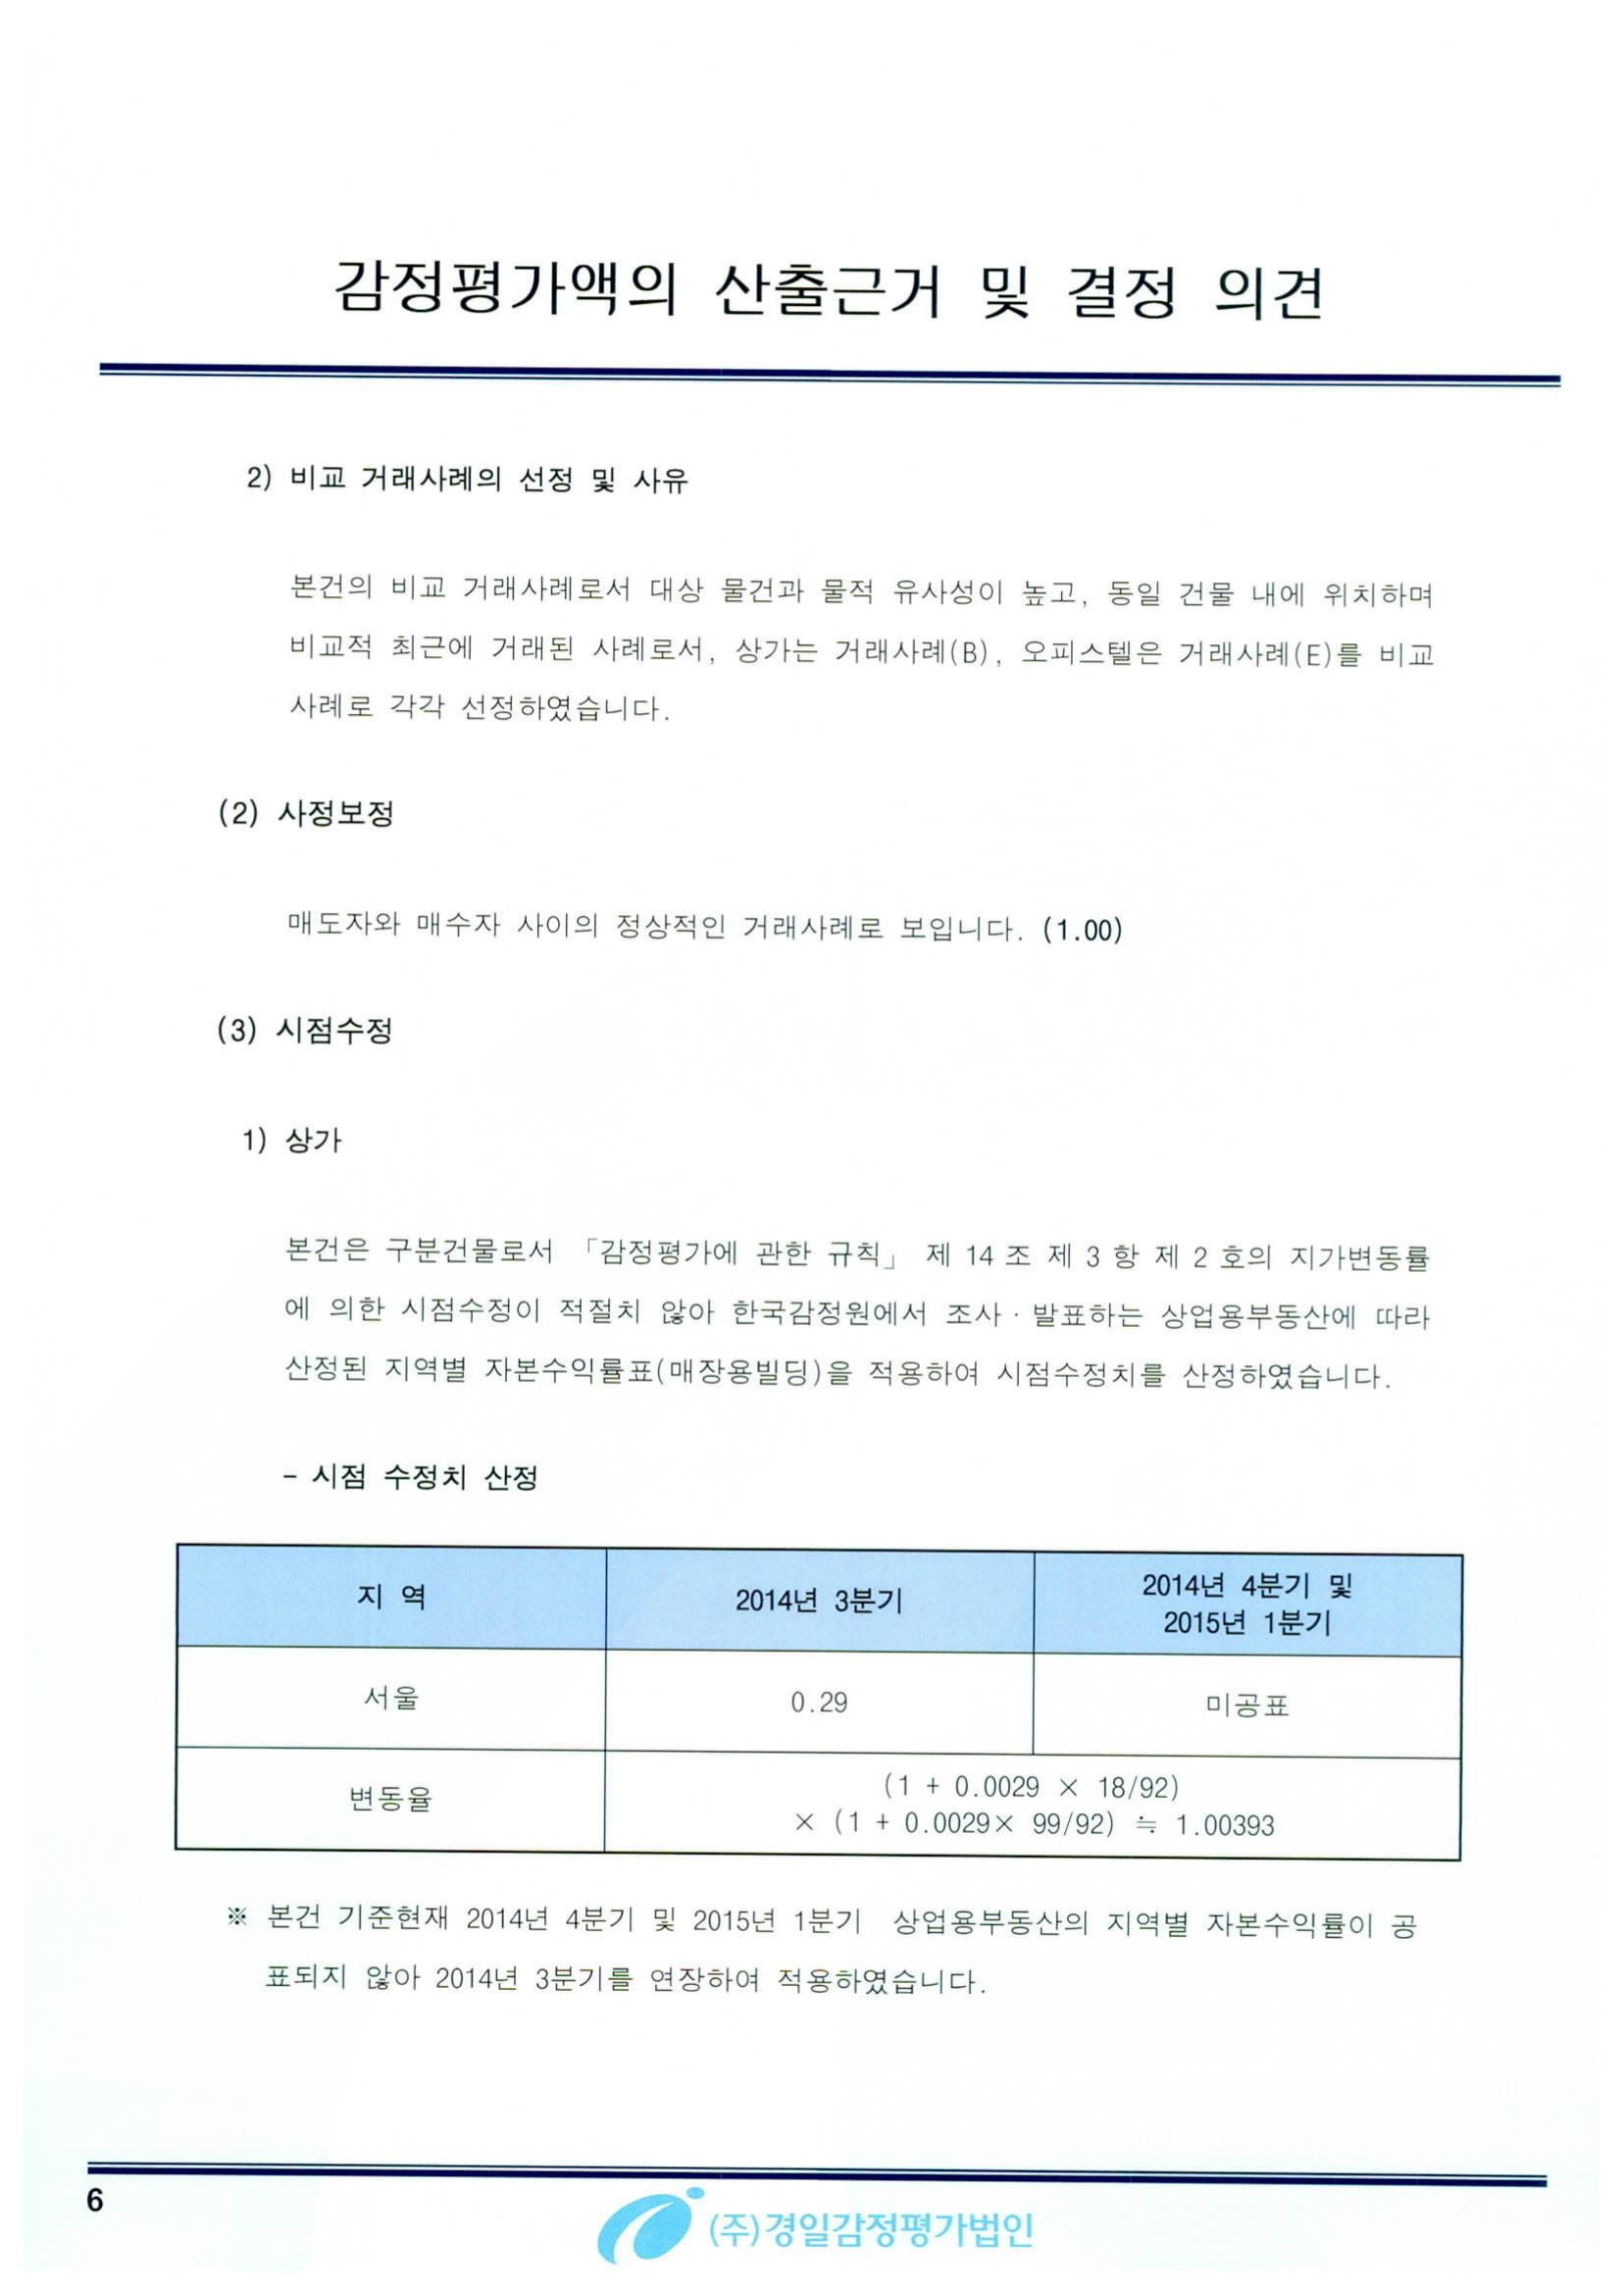

In [5]:
DATA_PATH = "/Users/iwonhaeng/Desktop/Data_copy/KAPA/images"
IMAGE_NAME = "2015022642"
PAGE = 11

image = load_page(image_dir=DATA_PATH, image_name=IMAGE_NAME, page=PAGE)
show(image)

## 기울기 보정

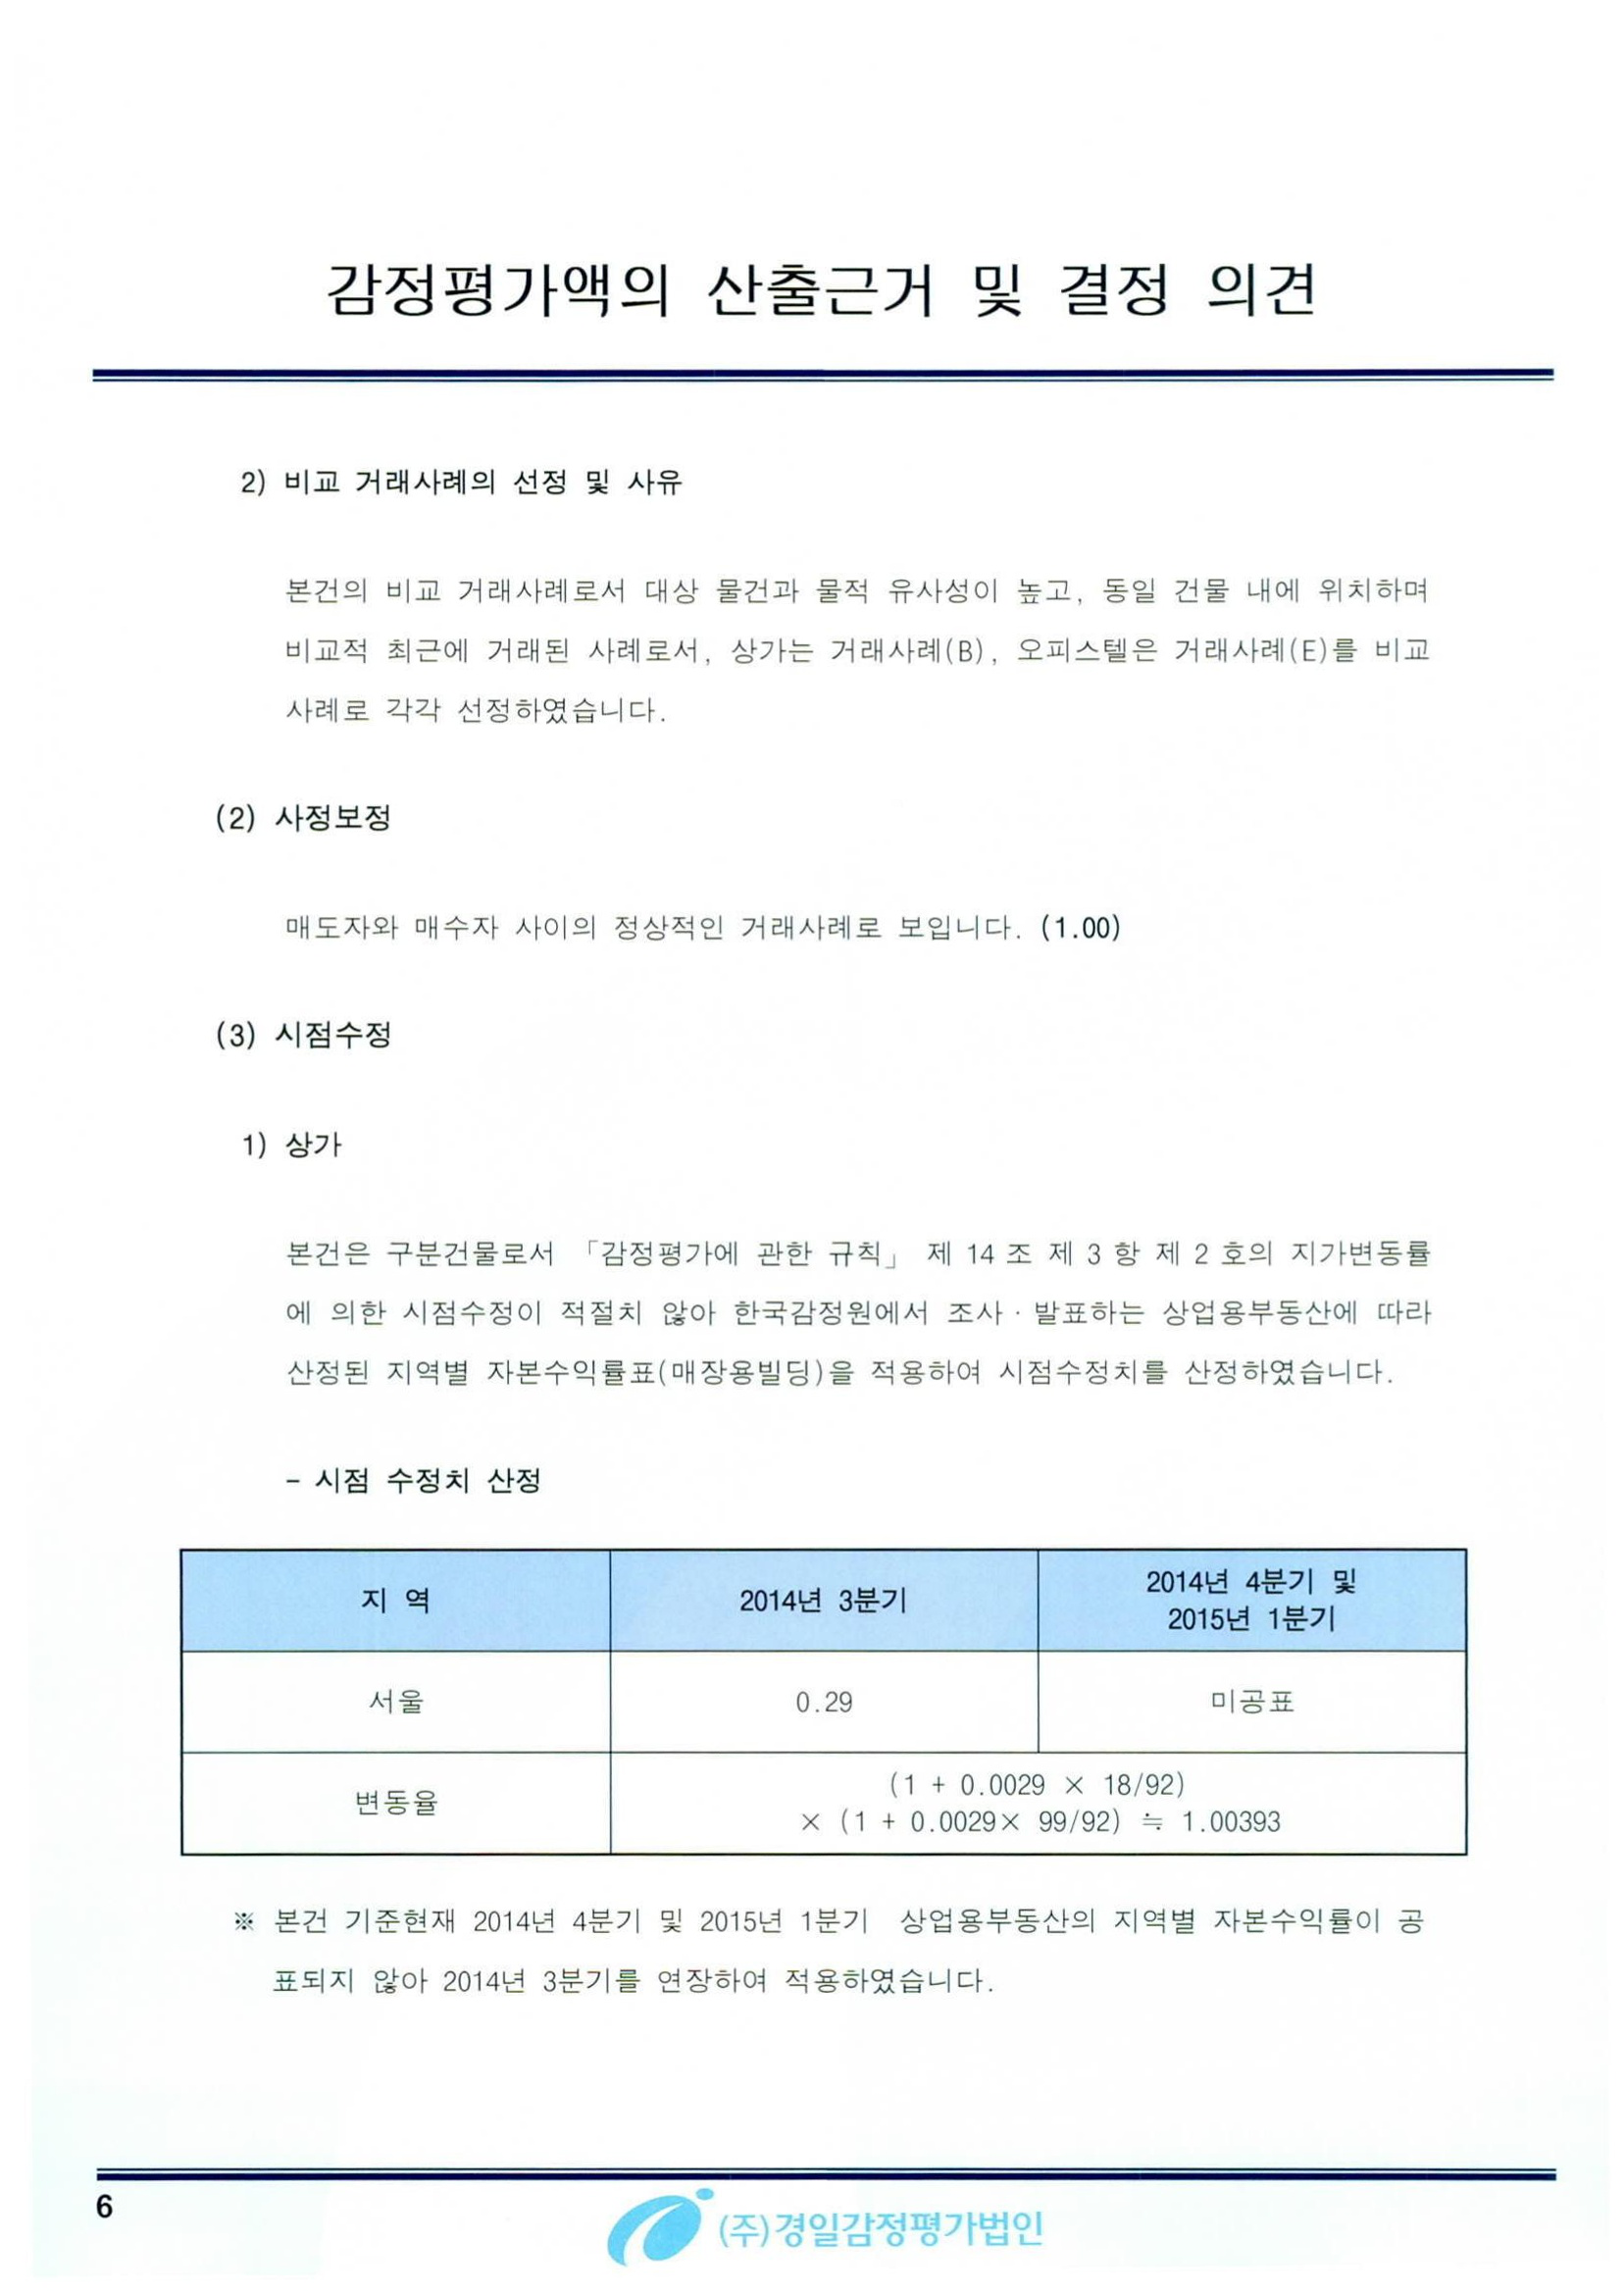

In [6]:
_, angle = rotate_threshold(find_table(image))

image = rotate_threshold(image, angle)[0]
show(image)

## 테이블(표), 외곽선 제거

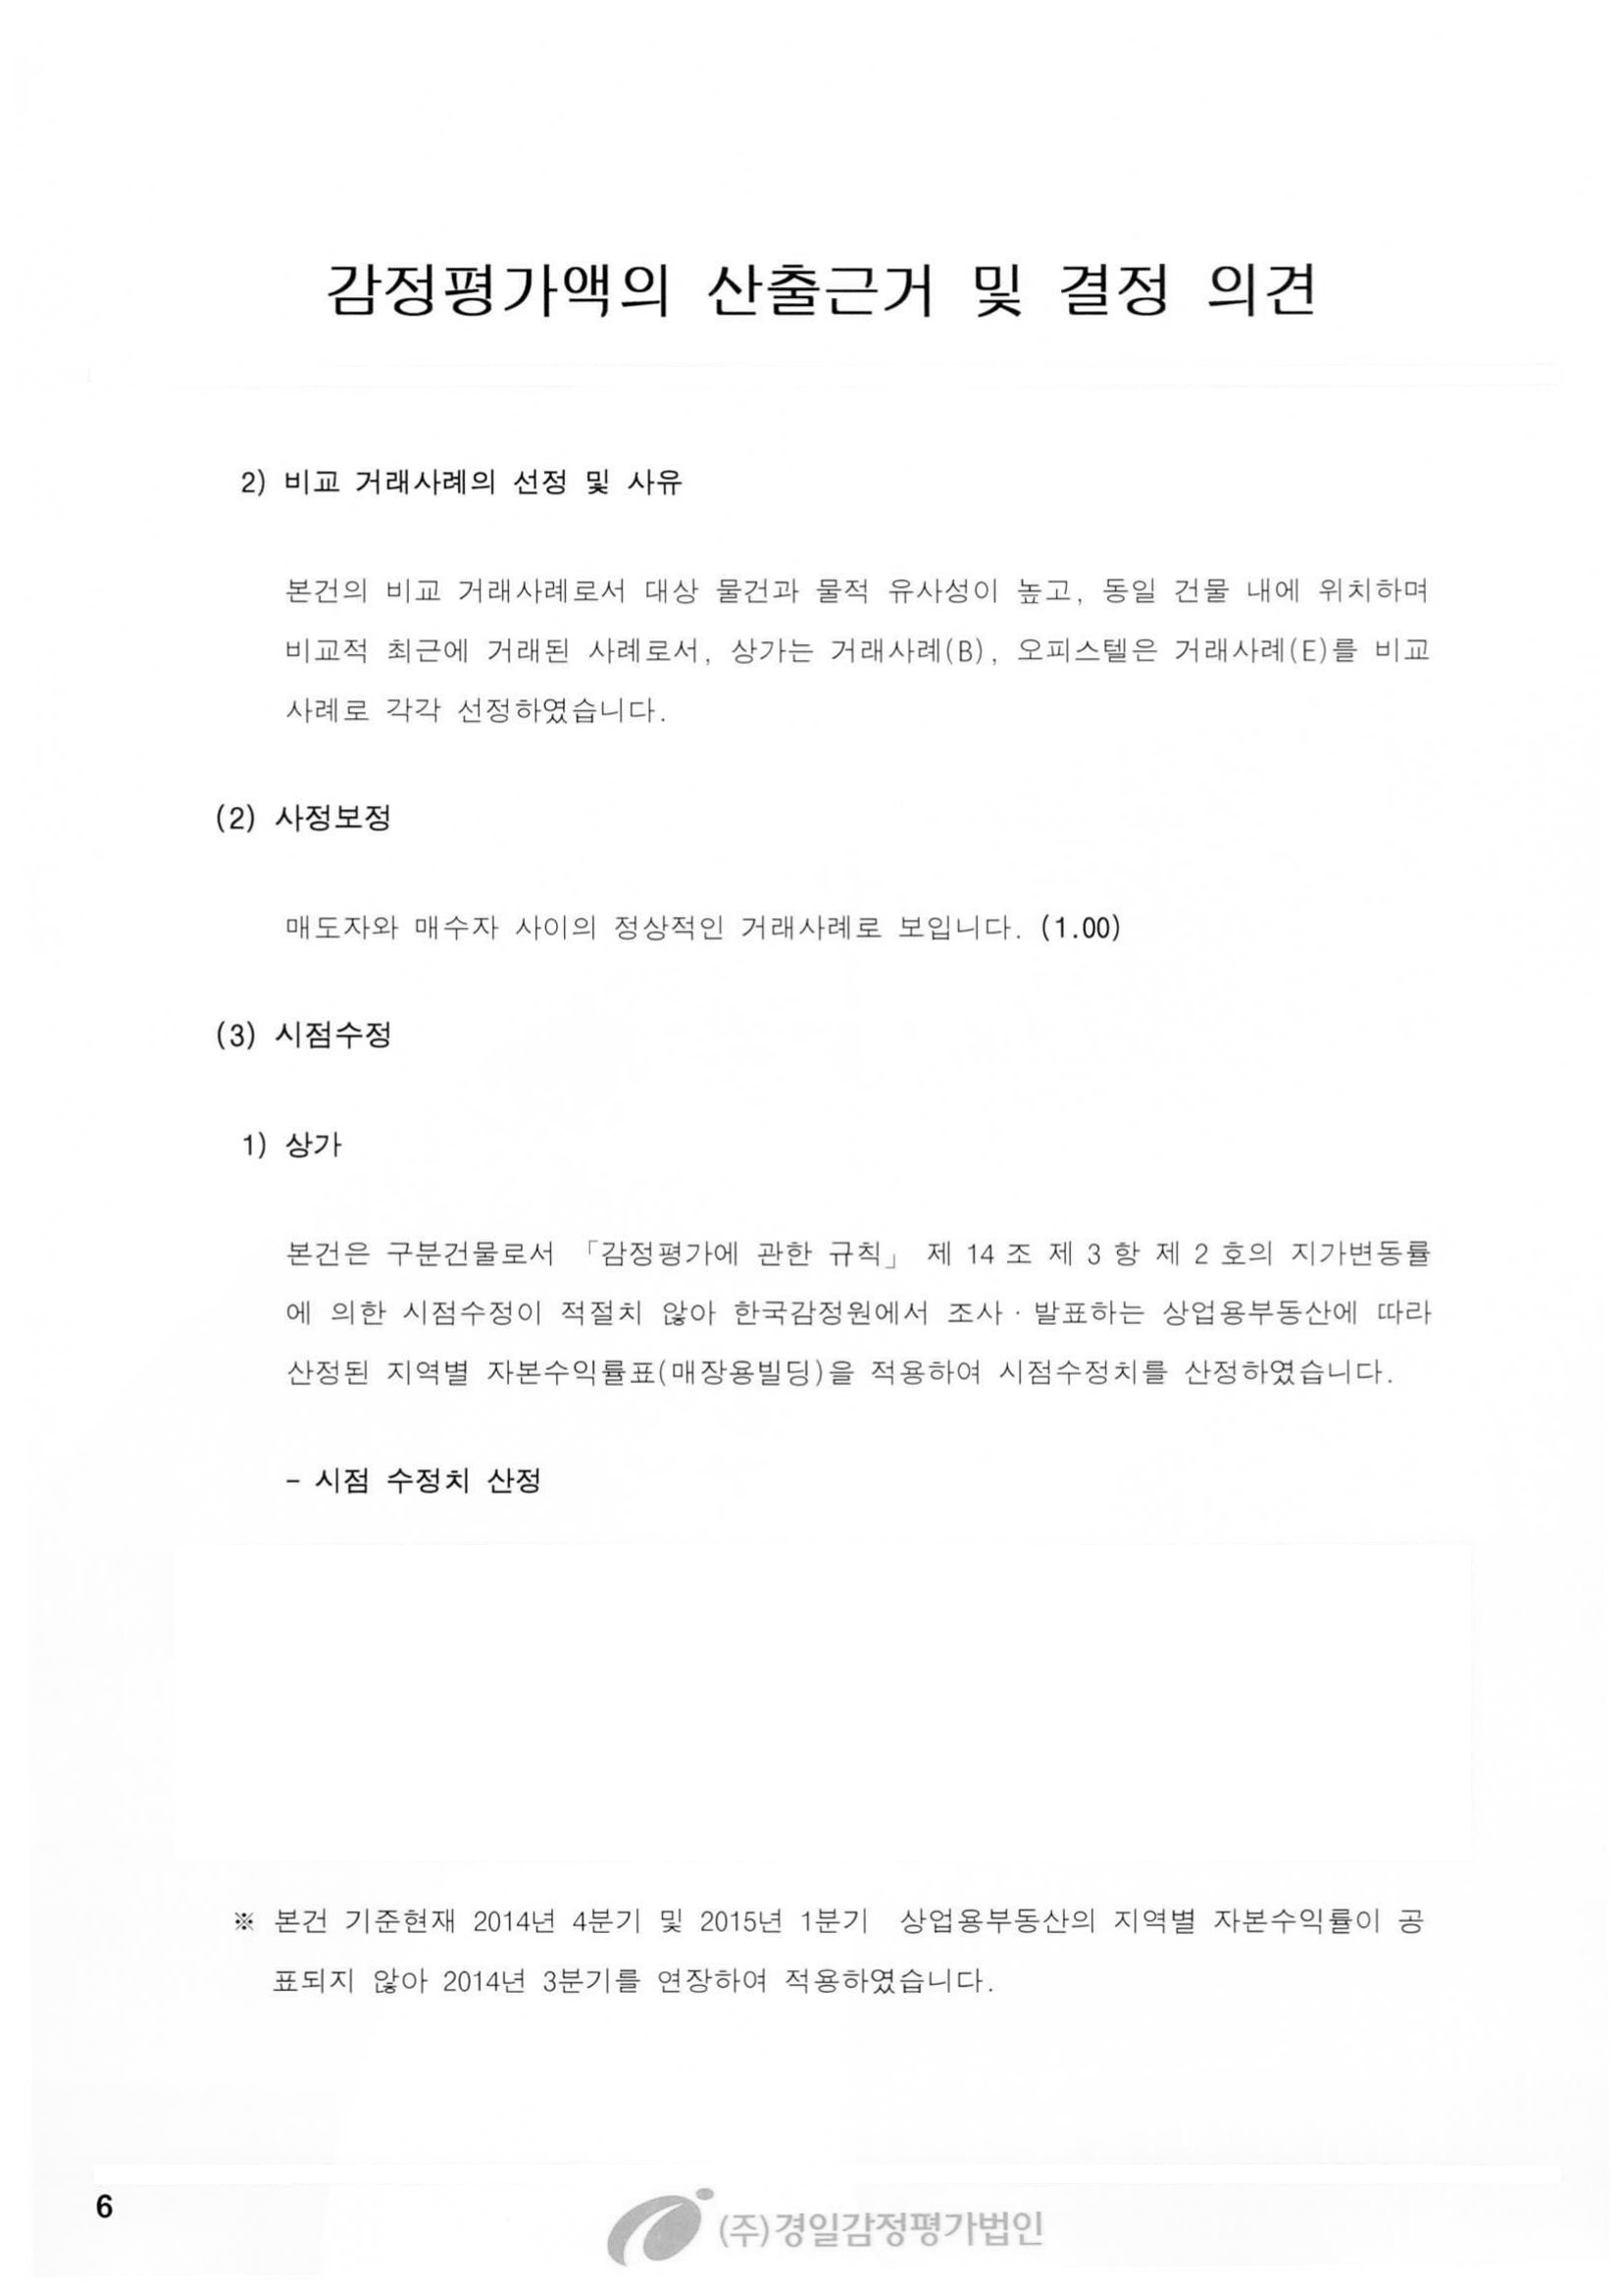

In [7]:
table_removed_image = remove_table_with_contents(image)
table_removed_image = remove_table(table_removed_image)

show(table_removed_image)

## 텍스트 유닛 검출

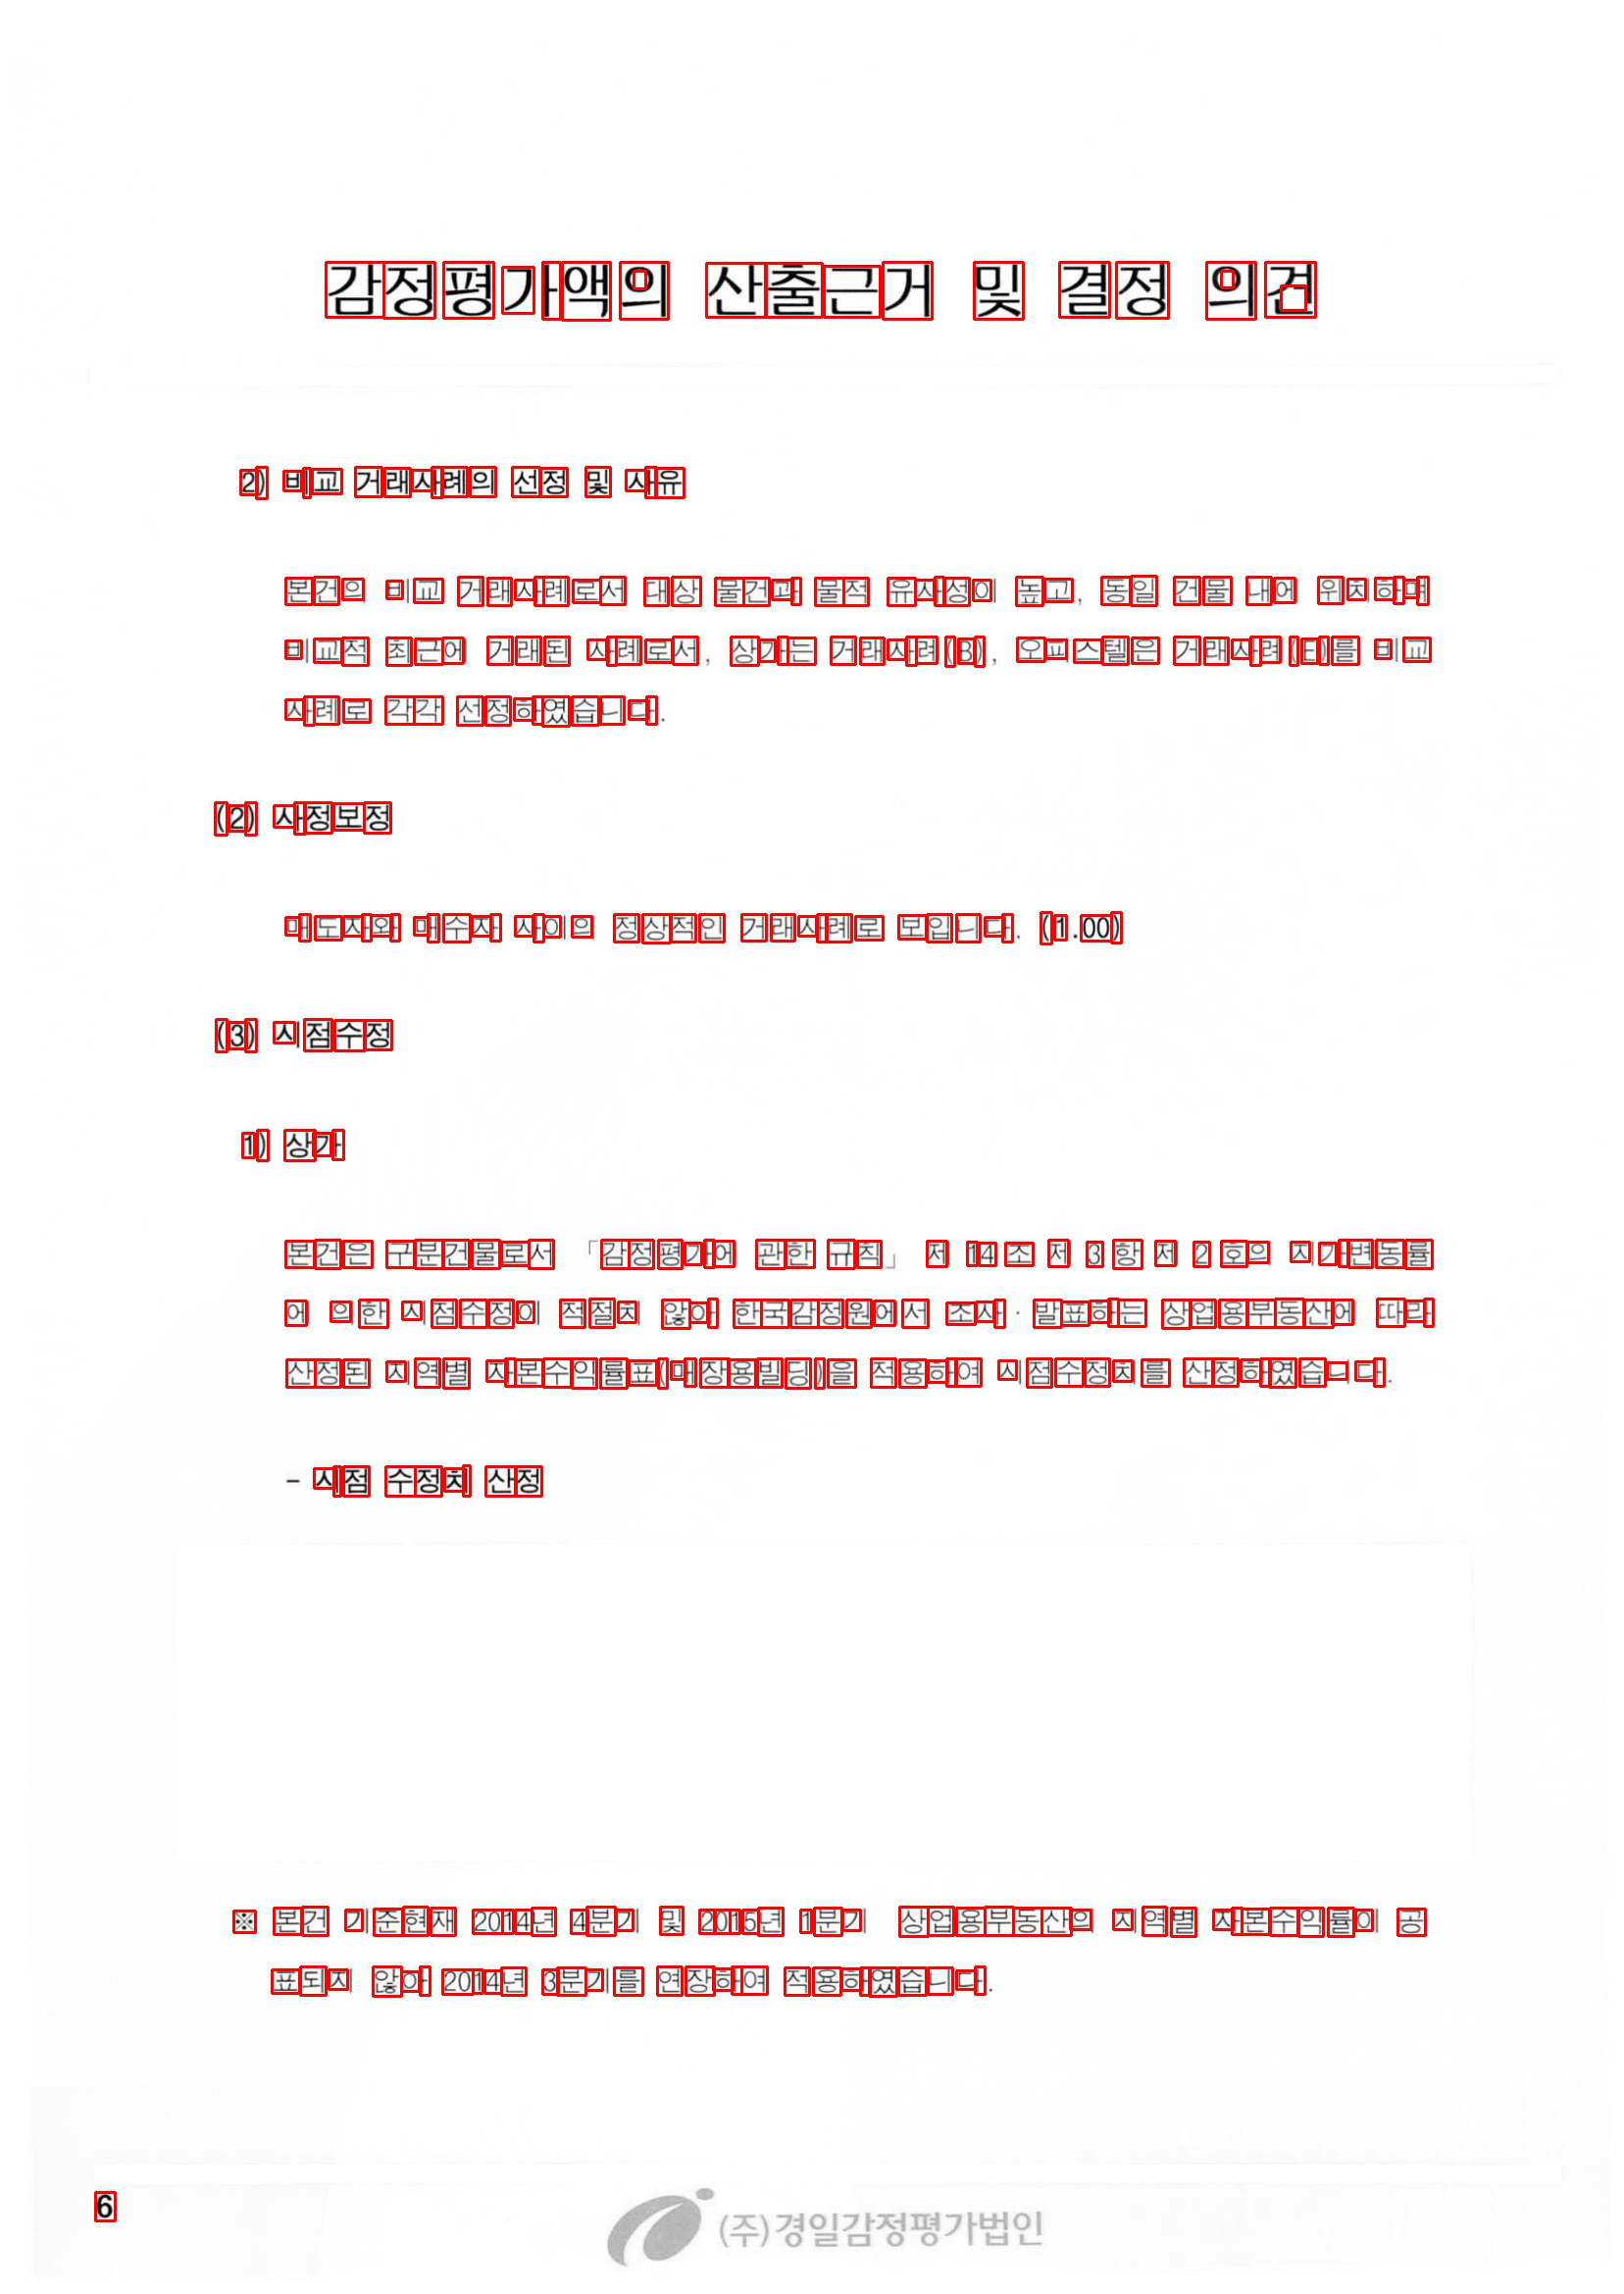

In [8]:
text_unit = text_unit_detector(image=table_removed_image)

show(text_unit)

## 텍스트 유닛을 같은 줄 단위로 결합

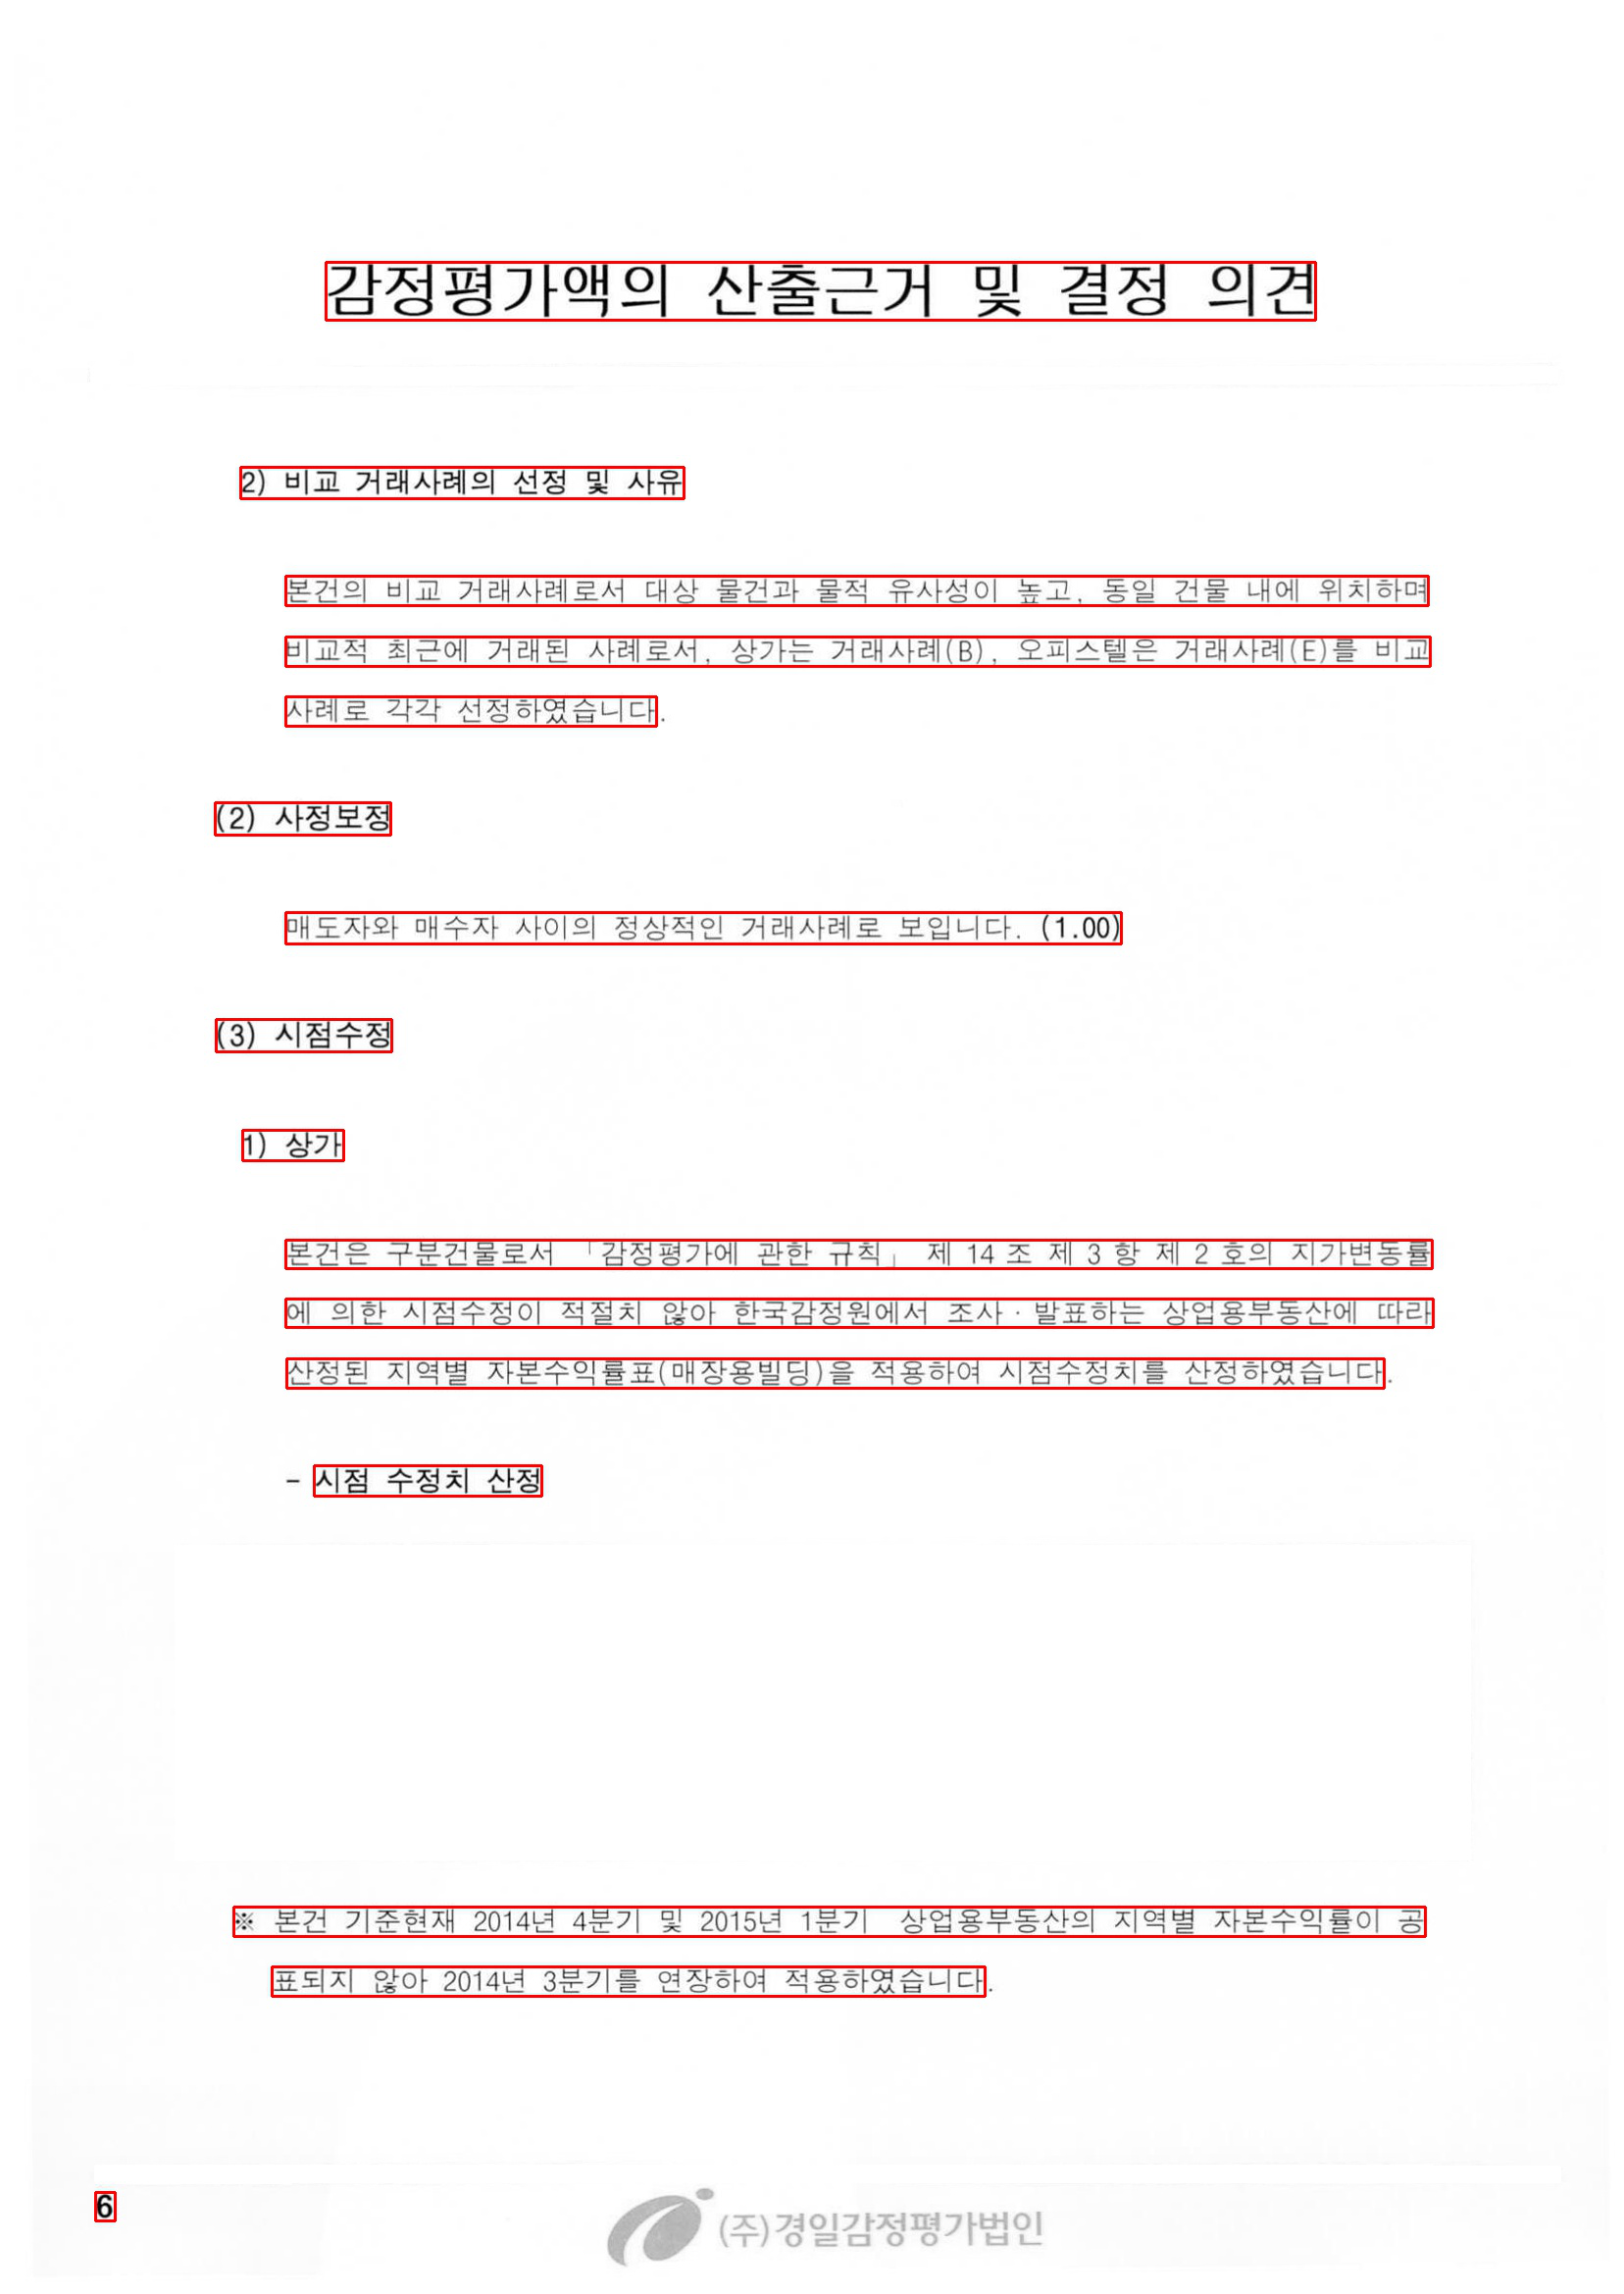

In [9]:
text_line_img, text_line_list = text_line_detecor(table_removed_image)

show(text_line_img)

## 줄 단위로 텍스트 인식

In [10]:
line2str(image=image, line_list=text_line_list)


2) 비교 거래사례의 선정 및 사유
본건의 비교 거래사례로서 대상 물건과 물적 유사성이 높고, 동일 건물 내에 위치하며
비교적 최근에 거래된 사례로서, 상가는 거래사례(8), 오피스텔은 거래사례(6)를 비교
사례로 각각 선정하였습니다
(2) 사정보정
매도자와 매수자 사이의 정상적인 거래사례로 보입니다. (1.00)
(3) 시점수정
1) 상가
본건은 구분건물로서 「감정평가에 관한 규칙」 제 14조제3 항제 2 호의 지가변동률
에 의한 시점수정이 적절치 않아 한국감정원에서 조사ㆍ발표하는 상업용부동산에 따라
산정된 지역별 자본수익률표(매장용빌딩)을 적용하여 시점수정치를 산정하였습니다
시점 수정치 산정
※ 본건 기준현재 2014년 4분기 및 2015년 1분기 상업용부동산의 지역별 자본수익률이 공
표되지 않아 2014년 3분기를 연장하여 적용하였습니다

